<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/6_1_chatbot_external_memory_with_our_db_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chatbot with message summarization & external DB memory
##Review
We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or "filtering messages" in graph state.

We've used these concepts in a Chatbot with 'memory' that produces a running summary of the conversation.

##Goals
###But, what if we want our Chatbot to have memory that persists indefinitely?

<li>Now, we'll introduce some more advanced checkpointers that support external databases.

<li>Here, we'll show how to use 'Sqlite' as a checkpointer, but other checkpointers, such as 'Postgres' are available!

Use Cases for Database File Management:
Fetching a Database File from a GitHub URL
Uploading a Database File from Your Local System
Accessing a Database File from Google Drive

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [3]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] ="Basic_chatbot"

gemini_api_key = userdata.get('Gemini-key')
os.environ["Gemini-key"] = gemini_api_key

#Sqlite
A good starting point here is the SqliteSaver checkpointer.

Sqlite is a small, fast, highly popular SQL database.

If we supply ":memory:" it creates an in-memory Sqlite database.

In [4]:
import sqlite3
# In memory - temporary database is created, not on-disk database
conn = sqlite3.connect(":memory:", check_same_thread = False)
#check_same_thread = False | allowing multiple threads to share and use the same SQLite database connection. By default it is True

#Default Behavior:
When you run the code for the first time, it will automatically fetch a new example.db file for you. But, if we supply a db path, then it will create a database for us!:

In [5]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2024-11-26 18:05:15--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2024-11-26 18:05:15--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.02s   

2024-11-26 18:05:16 (4.33 MB/s) - ‘s

#Mount with Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3
#file_path = '/content/drive/My Drive/state_db/example.db'
file_path = '/content/drive/MyDrive/Langchain/state_db/example.db'
conn = sqlite3.connect(file_path)

#When you want to pass your DB file:
You need `example.db` as well as `example.db-wal` file to retrieve your previous data.

##Sqlite uses these 3 files:

<li>example.db
<li>example.db-wal
<li>example.db-shm

How SQLite Uses These Files
**`example.db:`** This is the main database file where committed data is stored.

`example.db-wal:` If SQLite is in WAL mode, this file temporarily holds changes that have not been checkpointed (written to example.db). SQLite automatically reads from this file when you connect to the database.

`example.db-shm:` This file is used for shared memory when multiple connections are accessing the same database. It is a temporary file and does not affect persistence.

###Why you need to save example.db-wal file along with example.db file?

<li>Uncommitted Changes Are Stored in `example.db-wal:`

In WAL mode, SQLite writes all changes to the example.db-wal file instead of directly modifying the main example.db file.
These changes are only merged **(checkpointed)** into example.db when a checkpoint operation occurs.
If you only copy or use the example.db file without the example.db-wal, any uncommitted changes in the WAL file will be lost.

##Ensures Data Consistency:

If you transfer the database (example.db) to another system without the `example.db-wal`, the database may appear incomplete or inconsistent if there are pending writes stored in the WAL file.
**Concurrent Access:**

The WAL file allows multiple processes to read from the database while another process writes to it, without blocking each other. If this feature is in use, the `example.db-wal` file is essential for proper functionality.

In [8]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

**Let's re-define our chatbot.**

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  gemini_api_key)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

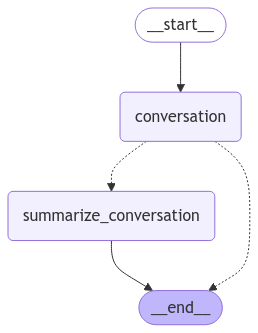

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about football.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 4
================================== Ai Message ==================================

To tell you about football, I need to know *which* football you mean.  There are several codes of football, each with its own rules and style of play.  The most popular are:

* **American Football:** Played primarily in the United States and Canada, this is a high-scoring, contact sport played with an oval-shaped ball.  Teams try to advance the ball down the field by running or passing, aiming to score touchdowns.  It's characterized by specialized positions, strategic plays, and significant use of protective equipment.

* **Association Football (Soccer):** This is the most popular sport globally.  Played with a round ball, two teams try to score by kicking the ball into the opposing team's goal.  It emphasizes speed, skill, and teamwork, with fewer specialized positions than American football.

* **Rugby Union and Rugby League:** These are both contact sports played with 

Now, we just re-compile with our sqlite checkpointer.

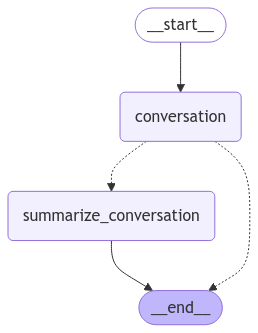

In [20]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about cricket.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 6
================================== Ai Message ==================================

Cricket is a bat-and-ball game played between two teams of eleven players on a field at the centre of which is a 22-yard pitch with a wicket at each end.  It's a complex game with a rich history and many nuances, but here's a breakdown of the basics:

**The Basics:**

* **The Objective:**  The batting team aims to score runs, while the bowling team aims to prevent this and dismiss (get out) the batsmen.

* **The Pitch:**  The pitch is the rectangular area in the center of the field where most of the action takes place.  It's carefully prepared and its condition significantly impacts the game.

* **The Wicket:**  Each wicket consists of three wooden stumps with two small bails balanced on top.  Dismissing a batsman involves hitting the wicket with the ball.

* **The Bat:**  A flat-bladed bat made of wood, used by the batsman to hit the ball.

* **The Ball:**  A hard, leathe

In [22]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 8
Messages before summarizing: 8
Existing summary: 
New summary: The conversation began with the user asking for information about "football," which led to a clarification that there are many types of football (American, soccer, rugby, Australian Rules, Gaelic).  After specifying their interest in "cricket," a detailed explanation of the game's basics, including scoring, dismissals, and different formats (Test matches, ODIs, T20), was provided.  The conversation concluded with the user asking for their name, to which the AI responded that it doesn't have access to personal information.

Messages after truncation: 6
================================== Ai Message ==================================

I do not know your name.  I have no access to personal information about you unless you explicitly provide it to me.
